In [1]:
import pandas as pd
from pandas import DatetimeIndex
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from datetime import timedelta
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from time import time

# Ice Cream Production Data

In [2]:
def parser(s):
    return datetime.strptime(s, '%Y-%m-%d')

In [3]:
production_ice_cream = pd.read_csv('../1_data/ice_cream.csv', parse_dates=[0], index_col=0, date_parser=parser).squeeze("columns") 

In [4]:
production_ice_cream.rename('production', inplace=True)

DATE
1972-01-01     59.9622
1972-02-01     67.0605
1972-03-01     74.2350
1972-04-01     78.1120
1972-05-01     84.7636
                ...   
2019-09-01    100.1741
2019-10-01     90.1684
2019-11-01     79.7223
2019-12-01     75.7094
2020-01-01     83.6290
Name: production, Length: 577, dtype: float64

In [5]:
production_ice_cream = production_ice_cream.asfreq(pd.infer_freq(production_ice_cream.index))

In [6]:
#just get data from 2010 onwards
start_date = pd.to_datetime('2010-01-01')
production_ice_cream = production_ice_cream[start_date:]

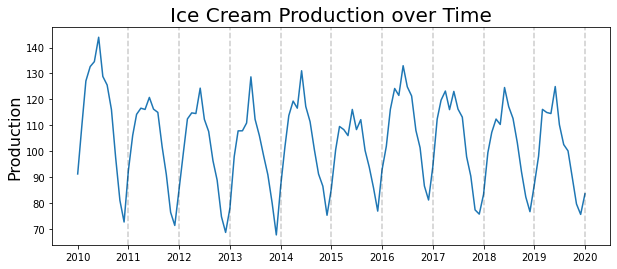

In [7]:
plt.figure(figsize=(10,4))
plt.plot(production_ice_cream)
plt.title('Ice Cream Production over Time', fontsize=20)
plt.ylabel('Production', fontsize=16)
for year in range(2011,2021):
    plt.axvline(pd.to_datetime(str(year)), color='k', linestyle='--', alpha=0.2)

## ACF

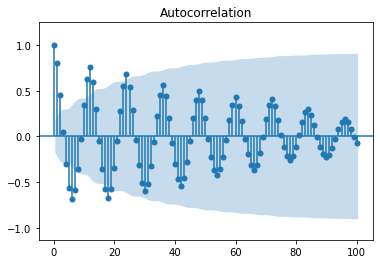

In [8]:
acf_plot = plot_acf(production_ice_cream, lags=100, auto_ylims=True)

## PACF

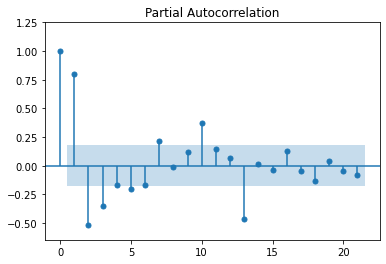

In [9]:
pacf_plot = plot_pacf(production_ice_cream, method='ywm', auto_ylims=True)

## Get test data

In [10]:
train_end = datetime(2016,12,1)
test_end = datetime(2019,12,1)

test_data = production_ice_cream[train_end + pd.DateOffset(months=1):test_end]

# M-Lead Rolling Forecast

## repeat:
### train until second to last month
### predict current month
### change current month to two months up

In [11]:
rolling_forecast_period = 2

In [12]:
#create the model
predictions_rolling = pd.Series(dtype=object)
for end_date in test_data.index[::rolling_forecast_period]:
    train_data = production_ice_cream[:end_date - pd.DateOffset(months=rolling_forecast_period)] #train end_date - M months down
    model = ARIMA(train_data[::rolling_forecast_period], order=(3,0,0))
    model_fit = model.fit()
    pred = model_fit.predict(end_date)  #predict current month (end-date)
    predictions_rolling.loc[end_date] = pred.loc[end_date]
    #print(predictions_rolling.index.date[-1], round(predictions_rolling.values[-1],6), test_data[end_date])

In [13]:
residuals_rolling = test_data[::rolling_forecast_period] - predictions_rolling

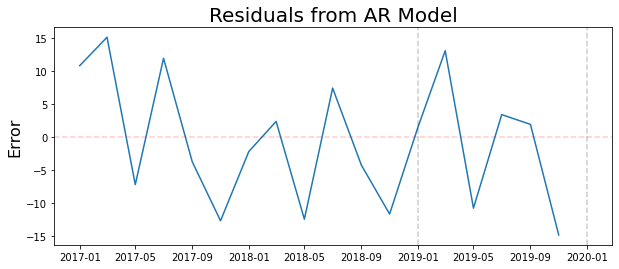

In [14]:
plt.figure(figsize=(10,4))
plt.plot(residuals_rolling)
plt.title('Residuals from AR Model', fontsize=20)
plt.ylabel('Error', fontsize=16)
plt.axhline(0, color='r', linestyle='--', alpha=0.2)
for year in range(2019,2021):
    plt.axvline(pd.to_datetime(str(year)), color='k', linestyle='--', alpha=0.2)

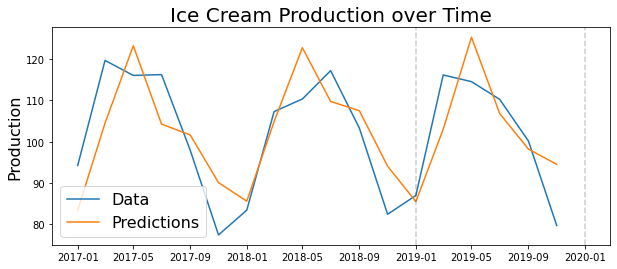

In [15]:
plt.figure(figsize=(10,4))

plt.plot(test_data[::2])
plt.plot(predictions_rolling)

plt.legend(('Data', 'Predictions'), fontsize=16)

plt.title('Ice Cream Production over Time', fontsize=20)
plt.ylabel('Production', fontsize=16)
for year in range(2019,2021):
    plt.axvline(pd.to_datetime(str(year)), color='k', linestyle='--', alpha=0.2)